In [4]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import pandas as pd
import numpy as np
import cv2  # conda install -c conda-forge opencv
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from scipy.signal import find_peaks


plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

results_save_path = "./results/data/leeching/"
os.makedirs(results_save_path, exist_ok=True)

# 1. Paths and Read-In (segmentation mask based)

In [5]:
# For the automation consider only the segemnted examples
masks_dir = "../data/videos/leeching/philodina/seg_masks/"
masks_path_names = sorted([dir for dir in os.listdir(masks_dir) if dir.endswith("masks")])
mask_filepaths = [f"{masks_dir}{mpath}/"for mpath in masks_path_names]

# Corresponding videos
vid_path = "../data/videos/leeching/philodina/ori_videos/"
vid_filenames = [fn.split("_masks")[0] + ".MP4" for fn in masks_path_names]
vid_props = {k : get_video_properties(vid_path, k) for k in vid_filenames}
df = pd.DataFrame.from_dict(vid_props, orient="index").reset_index()
df.columns = ["filename", "fps", "num_frames", "width", "height"]
#df.to_csv("./data/results/leeching/df.csv", index=False)

# Scale
pixel_per_real_width =  2.127659 #  >> for Dlow
mpp = 0.47 # microns_per_pixel for Dlow
print("D low - FHD, pixel_per_real_width = ", pixel_per_real_width)
 
df

D low - FHD, pixel_per_real_width =  2.127659


,filename,fps,num_frames,width,height
0,2024_0430_200515_048.MP4,60,2354,1920,1080
1,2024_0502_183848_065.MP4,60,1038,1920,1080
2,2024_0502_184114_068.MP4,60,843,1920,1080
3,2024_0502_184450_071.MP4,60,2074,1920,1080
4,2024_0502_184534_072.MP4,60,2156,1920,1080
5,2024_0502_184616_073.MP4,60,1372,1920,1080
6,2024_0502_184929_077.MP4,60,776,1920,1080
7,2024_0502_184947_078.MP4,60,756,1920,1080
8,2024_0502_185400_083.MP4,60,1333,1920,1080
9,2024_0502_185557_084.MP4,60,1648,1920,1080


# 2. Loop over recordings

In [6]:
# Get Segmentation masks > results of tracking
autocorr_idx = [2,3,4,6,7,8,9,10,11]
autocorr_results = []
perimeters = []

ROTATE_MASKS = True
SAVE_DFs = True

for cidx in range(len(df)):
    vid_filename = df.loc[cidx, "filename"]; print(vid_filename)
    fps = df.loc[cidx, "fps"]
    num_frames = df.loc[cidx, "num_frames"]
    cmask_filepath = mask_filepaths[cidx]

    # Masks
    cmask_filenames = sorted([f for f in os.listdir(cmask_filepath) if f.endswith("png")])
    cmask_filepaths = [os.path.join(cmask_filepath, fn) for fn in cmask_filenames]

    # Get contours from masks
    frames = np.arange(0, len(cmask_filepaths))
    time = np.linspace(0, num_frames / fps, num_frames)
    contour_list = get_contours_from_segmasks(cmask_filepaths)

    # Get contour stats
    df_stats = get_contour_stats(contour_list, min_area=2200)
    print(df_stats["area"].min())

    # Save figures
    #results_path = "./data/results/leeching/"
    save_figure_path = os.path.join(results_save_path, vid_filename.split(".MP4")[0])
    #os.makedirs(save_figure_path, exist_ok=True)

    # export selected frames only
    EXPORT_FRAMES = False
    export_frames = np.arange(0, len(frames))  # export frames, rather!
    img_save_dir = f"../data/images/{vid_filename.split('.MP4')[0]}/"
    export_selected_frames(os.path.join(vid_path, vid_filename), img_save_dir, export_frames) if EXPORT_FRAMES else None

    # Plot
    # fig, ax = plt.subplots(1, 1, figsize=(6, 3))
    # ax.plot(frames, df_stats["perimeter"], "-k")
    # ax.set_xlim(0, len(frames))
    # ax.set_xlabel("frames")
    # ax.set_title(f"idx {cidx} - {vid_filename}")
    # ax.minorticks_on()
    #fig.savefig(f"{save_figure_path}/perimeter_frames-course.jpg", dpi=600, bbox_inches='tight')
    
    if ROTATE_MASKS:
        # ROTATE MASKS AND CONTOURS - Rotatation parameters
        cm_x, cm_y = df_stats[["centroid_x", "centroid_y"]].values.T
        centers = [(x, y) for x, y in zip(cm_x, cm_y)]
        rot_angles = df_stats["orientation"].values  # fitted ellipse angle
        # rotate masks and get rotated contours
        rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, cmask_filepaths)
        # find top and bottom most points
        df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
        df_points = transform_points_to_original_space(df_top_bot, centers, rot_angles * -1)

    if SAVE_DFs:
        df_stats.to_csv(f"{save_figure_path}_df_stats.csv", index=False)
        df_top_bot.to_csv(f"{save_figure_path}_df_top_bot.csv", index=False)
        df_points.to_csv(f"{save_figure_path}_df_points.csv", index=False)

2024_0430_200515_048.MP4
2200.0
2024_0502_183848_065.MP4
2451.5
2024_0502_184114_068.MP4
2219.0
2024_0502_184450_071.MP4
2201.5
2024_0502_184534_072.MP4
2261.0
2024_0502_184616_073.MP4
2214.5
2024_0502_184929_077.MP4
3907.0
2024_0502_184947_078.MP4
4086.0
2024_0502_185400_083.MP4
2377.5
2024_0502_185557_084.MP4
4864.5
2024_0502_192159_105.MP4
2237.5
2024_0502_192334_108.MP4
5283.5
2024_0502_193112_114.MP4
4814.0
2024_0502_193145_115.MP4
3215.5


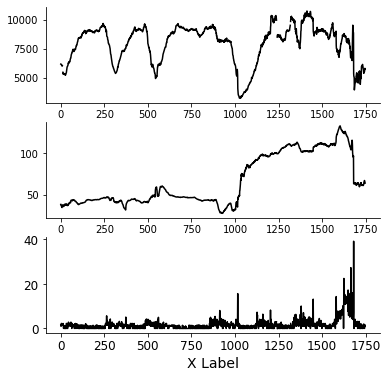

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6))

ax[0].plot(df_stats["area"], "-k")
ax[1].plot(df_stats["orientation"], "-k")
ax[2].plot(df_stats["centroid_dist"], "-k")

ax[2].set_xlabel('X Label', fontsize=14)  # Adjust font size as needed
ax[2].set_ylabel('', fontsize=14)  # Adjust font size as needed
ax[2].tick_params(axis='both', which='major', labelsize=12)  # Adjust tick label font size

# Save the figure
#fig.savefig('my_figure.jpg', dpi=600, bbox_inches='tight')  # Specify resolution and tight bounding box

# 2. Rotate Masks and Contours

In [8]:
# Rotatation parameters
cm_x, cm_y = df_stats[["centroid_x", "centroid_y"]].values.T
centers = [(x, y) for x, y in zip(cm_x, cm_y)]
rot_angles = df_stats["orientation"].values  # fitted ellipse angle

# rotate masks and get rotated contours
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, cmask_filepaths)

# find top and bottom most points
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
# cut_width, cut_height = ()

# 3. Show examples

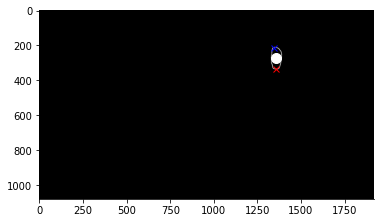

In [9]:
idx = 2
cmask = cv2.cvtColor(cv2.imread(cmask_filepaths[idx], 1), cv2.COLOR_BGR2GRAY)
background = np.zeros_like(cmask)

cv2.drawContours(background, [rot_contours[idx]], 0, (255,0,0), thickness=2)
plt.imshow(background, cmap="gray")
plt.plot(cm_x[idx], cm_y[idx], "ow", ms=10)

plt.plot(df_top_bot.loc[idx, "top_x"], df_top_bot.loc[idx, "top_y"], "xb", ms=6)
plt.plot(df_top_bot.loc[idx, "bottom_x"], df_top_bot.loc[idx, "bottom_y"], "xr", ms=6)